In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pingouin as pg


from ssri_interactions.config import Config, ExperimentInfo
from ssri_interactions.plots.heatmaps import similarity_map
from ssri_interactions.plots.umap import plot_umap
from ssri_interactions.io import load_derived_generic

c:\ProgramData\Miniconda3\envs\ssri\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
sns.set_theme(style="ticks", context="paper")

In [3]:
# Spike Heatmap [of an example recording or all neurons]

neuron_types = load_derived_generic("neuron_types.csv")
cit_neurons = neuron_types.query("group == 'CIT'").neuron_id.unique()
sal_neurons = neuron_types.query("group == 'SAL'").neuron_id.unique()

df_counts = (
    pd.read_parquet(Config.derived_data_dir / "spike_counts_around_footshock.parquet")
    .query("bin <= 600")
)
df_f1_pop = load_derived_generic(
    "decoding/fs_slow - shock only - pop.csv"
)
df_f1_unit = load_derived_generic(
    "decoding/fs_slow - shock only - unit.csv"
)
df_decoding = (
    df_f1_unit
    .groupby("session_name")["F1 Score"].max()
    .to_frame("Best Neuron")
    .reset_index()
    .merge(
        df_f1_pop.rename(columns=dict(pop_true="Population", shuffle="Shuffle")),
        on="session_name"
        )
    .melt(id_vars="session_name", var_name="metric", value_name="value")
    .assign(metric = lambda x: pd.Categorical(x.metric, categories=["Population", "Best Neuron", "Shuffle"]))
    .merge(neuron_types[["session_name", "group"]].drop_duplicates(), on="session_name")
)

df_counts_piv_all = df_counts.pivot_table(index="bin", columns="neuron_id", values="zcounts")
df_counts_piv_cit = df_counts_piv_all[[c for c in df_counts_piv_all.columns if c in cit_neurons]]
df_counts_piv_sal = df_counts_piv_all[[c for c in df_counts_piv_all.columns if c in sal_neurons]]

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x18b3f051880>)

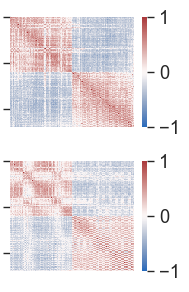

In [32]:
# Corresponding Similarity Map

f = plt.figure(figsize=(2, 3.3))

ax_sal, ax_cit = f.subplots(2, 1, gridspec_kw=dict(hspace=0.3))

similarity_map(
    df_binned_piv=df_counts_piv_sal,
    z=True, 
    ax=ax_sal,
    heatmap_kwargs=dict(cmap="vlag", vmin=-1, vmax=1, robust=True)
    )

similarity_map(
    df_binned_piv=df_counts_piv_cit,
    z=True, 
    ax=ax_cit,
    heatmap_kwargs=dict(cmap="vlag", vmin=-1, vmax=1, robust=True)
    )

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x18bcd4c87c0>)

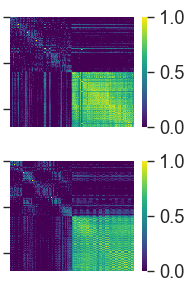

In [33]:
f = plt.figure(figsize=(2, 3.3))
ax_sal, ax_cit = f.subplots(2, 1, gridspec_kw=dict(hspace=0.3))

similarity_map(
    df_binned_piv=df_counts_piv_sal,
    z=False, 
    ax=ax_sal,
    heatmap_kwargs=dict(cmap="viridis", vmin=0, vmax=1, robust=True)
    )

similarity_map(
    df_binned_piv=df_counts_piv_cit,
    z=False, 
    ax=ax_cit,
    heatmap_kwargs=dict(cmap="viridis", vmin=0, vmax=1, robust=True)
    )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot:xlabel='UMAP-1', ylabel='UMAP-2'>

<Figure size 400x400 with 0 Axes>

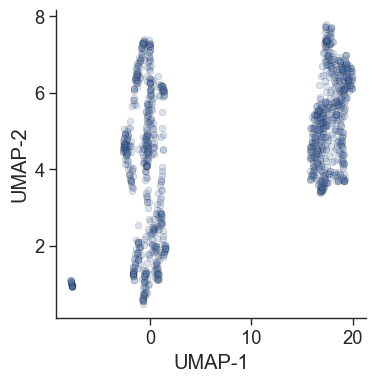

In [34]:
from ssri_interactions.umap import umap_spikes
from ssri_interactions.plots.umap import plot_umap

df_umap_sal = umap_spikes(df_counts_piv_sal)
df_umap_cit = umap_spikes(df_counts_piv_cit)

f = plt.figure(figsize=(4, 4))
f_sal, f_cit = f.subfigures(ncols=2)


# plot_umap_ts(df_umap_sal, f_sal, color="black")
# plot_umap_ts(df_umap_cit, f_cit, color="black")


plot_umap(df_umap_sal,)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot:xlabel='UMAP-1', ylabel='UMAP-2'>

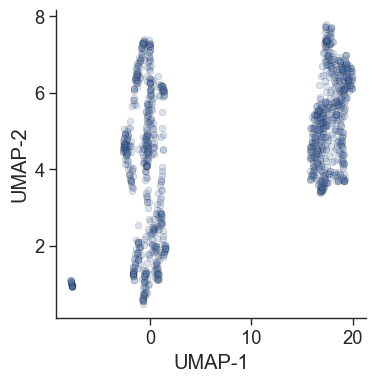

In [35]:
plot_umap(df_umap_sal,)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot:xlabel='UMAP-1', ylabel='UMAP-2'>

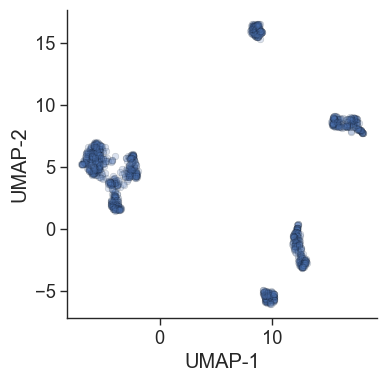

In [36]:
plot_umap(df_umap_cit,)


## Decoding

### Bar plots

#### Best Neuron by group

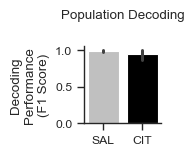

In [22]:
from ssri_interactions.plots.pallets_cmaps import PAL_GREY_BLACK

f = plt.figure(figsize=(1, 1))
ax_pop = f.subplots(1, 1)
sns.barplot(
    data=df_decoding.query("metric == 'Population'"),
    x="group",
    y="value",
    ax=ax_pop,
    palette=PAL_GREY_BLACK[::-1],
)

ax_pop.set_ylabel("Decoding\nPerformance\n(F1 Score)")
ax_pop.set_xlabel("")
ax_pop.set_title("Population Decoding", pad=20)
sns.despine(fig=f)

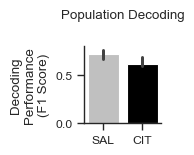

In [38]:
f = plt.figure(figsize=(1, 1))
ax_neuron = f.subplots(1, 1)

df_unit = df_f1_unit.merge(neuron_types[["session_name", "neuron_id", "neuron_type", "group"]])

sns.barplot(
    data=df_unit.query("neuron_type == 'SR'"),
    x="group",
    y="F1 Score",
    ax=ax_neuron,
    palette=PAL_GREY_BLACK[::-1],
    estimator=np.median,
)

ax_neuron.set_ylabel("Decoding\nPerformance\n(F1 Score)")
ax_neuron.set_xlabel("")
ax_neuron.set_title("Population Decoding", pad=20)
sns.despine(fig=f)

c:\ProgramData\Miniconda3\envs\ssri\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
c:\ProgramData\Miniconda3\envs\ssri\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


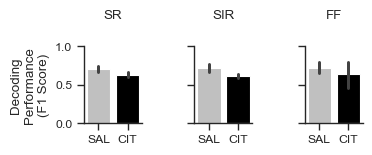

In [51]:
g = sns.FacetGrid(
    data=df_unit,
    col="neuron_type",
    col_order=["SR", "SIR", "FF"],
    height=1,
    aspect=1.2,
    gridspec_kws=dict(wspace=0.9),
)
g.map_dataframe(
    sns.barplot, 
    x="group", 
    y="F1 Score", 
    palette=PAL_GREY_BLACK[::-1],
    # estimator=np.median
)

# ax_neuron = g
g.set_ylabels("Decoding\nPerformance\n(F1 Score)")
g.set_xlabels("")
g.set_titles("{col_name}", pad = 20)

for ax in g.axes.flatten():
    ax.set_ylim(0, 1)




#### Number of Neurons by Group

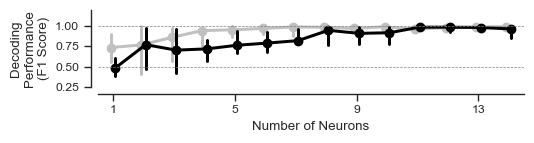

In [52]:
from ssri_interactions.plots.pallets_cmaps import PAL_GREY_BLACK

limit = (
    load_derived_generic("decoding/fs_slow - shock only - limit.csv")
    .merge(neuron_types[["session_name", "group"]].drop_duplicates())
)

f = plt.figure(figsize=(5.5, 1))

ax_line = f.subplots()
ax_line.set_ylim(0.25, 1.2)
ax_line.set_yticks([0.25, 0.5, 0.75, 1])
sns.pointplot(
    data=limit, 
    x="n_neurons", 
    y="pop_score", 
    hue="group", 
    estimator=np.median,
    ax=ax_line,
    palette=PAL_GREY_BLACK[::-1],
    dodge=0.15,
)

ax_line.xaxis.set_major_locator(plt.MultipleLocator(4))
ax_line.set_ylabel("Decoding\nPerformance\n(F1 Score)")
ax_line.set_xlabel("Number of Neurons")
ax_line.axhline(0.5, color="grey", linewidth=0.5, linestyle="--")
ax_line.axhline(1, color="grey", linewidth=0.5, linestyle="--")
f.subplots_adjust(wspace=1, hspace=1.4)
sns.despine(fig=f)
sns.despine(ax=ax_line, offset=5)
ax_line.legend_.remove()